## Project Objective

The primary goal of this project is to **develop a robust and accurate predictive model** that can estimate housing prices in **Tehran**, using structured tabular data collected from real estate listings.

This model aims to assist stakeholders such as **buyers, sellers, urban planners, and developers** in understanding price trends and making informed decisions based on property features.

To achieve this, I followed a well-defined, end-to-end data science workflow, which consists of the following stages:

---

### 1. Meet and Greet the Data  
- Loaded the dataset and explored its structure, types, and distributions.
- Performed initial quality checks and identified data types, formats, and completeness.

### 2. Exploratory Data Analysis (EDA)  
- Conducted statistical profiling and visualizations to uncover data patterns, trends, and relationships.
- Analyzed key features like **Area, Room count, Facilities, Neighborhood**, and their correlation with price.
- Investigated the effect of categorical variables such as **Parking, Elevator, and Warehouse** on pricing.
- Detected and examined **outliers** and skewness in price and area distributions.

### 3. Handling Missing Values  
- Addressed missing values using appropriate imputation strategies:
  - For example, imputing missing `Area` based on average area per room.
  - Dropping rows with missing but non-critical values like `Address` (when limited in count).

### 4. Feature Engineering  
- Created new variables to capture complex relationships:
  - `Facilities_sum`: total number of available facilities (Parking, Warehouse, Elevator).
  - `Room_per_Area`: density of rooms relative to total area.
  - `Neighborhood_house_count`: frequency of listings per neighborhood as a proxy for location popularity.
- These engineered features enriched the dataset and significantly boosted model performance.

### 5. Data Preprocessing  
- Converted categorical variables into numerical form (e.g., label encoding for `Address`).
- Applied log transformation to skewed variables like `Price` and `Area`.
- Standardized selected features where needed, particularly for neural network training.

### 6. Model Training and Evaluation  

#### 6.1 Traditional Machine Learning Models  
- Trained multiple regression models including:
  - Linear Regression, Ridge, Lasso
  - Decision Tree, Random Forest
  - Gradient Boosting models: **XGBoost, LightGBM, CatBoost**
  - K-Nearest Neighbors and MLP Regressor
- Evaluated performance using **MAE, RMSE, and R²** metrics under different preprocessing scenarios.

#### 6.2 Deep Learning Model  
- Implemented a **fully connected ANN** using TensorFlow/Keras.
- Designed with Batch Normalization and Early Stopping to stabilize and optimize training.
- Compared its performance against tree-based ensembles to test effectiveness on structured data.

---

### 7. Summary and Final Insights  
- Compared top-performing models based on predictive accuracy and generalization capability.
- Found **XGBoost** and **Stacking Ensemble** models to be most effective, followed closely by the ANN model.
- Highlighted the critical impact of feature engineering, log-transformation, and model selection on final performance.

---

### Final Goal

The ultimate aim of this project is to identify the most reliable and generalizable model for **housing price prediction in Tehran**, one that can be leveraged as a decision-support tool or serve as the basis for a production-grade real estate valuation system.

This work not only demonstrates core data science skills—**from data wrangling to advanced modeling**—but also bridges the gap between technical analysis and real-world applicability in urban economic contexts.


0 - Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from copy import deepcopy
%matplotlib inline

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

## Environment Setup & Library Imports

To begin the project, I imported a comprehensive set of libraries covering all essential stages of the machine learning pipeline. These include:

- **Data manipulation and analysis**: `pandas`, `numpy`
- **Data visualization**: `matplotlib`, `seaborn`
- **Statistical techniques**: `scipy.stats` (for outlier handling via winsorization)
- **Preprocessing and evaluation**: `scikit-learn` modules for:
  - scaling
  - encoding
  - train-test splitting
  - model training and evaluation (MAE, RMSE, R²)
- **Machine Learning models**: 
  - Linear models: `LinearRegression`, `Ridge`, `Lasso`  
  - Tree-based models: `DecisionTreeRegressor`, `RandomForestRegressor`  
  - Instance-based models: `KNeighborsRegressor`  
  - Ensemble models: `VotingRegressor`, `StackingRegressor`
- **Boosting algorithms**: `XGBoost`, `LightGBM`, and `CatBoost`
- **Neural Networks**: Built using `TensorFlow` and `Keras` (`Sequential`, `Dense`, `Adam`)
- **Hyperparameter optimization**: `Optuna` was used to tune model parameters automatically.

This wide variety of tools and libraries provided the flexibility to experiment with various modeling techniques and find the most effective one for housing price prediction.


## 1 - Meet and Greet the Data

The dataset used in this project is a structured CSV file containing detailed information about residential properties in **Tehran**. The data was loaded using `pandas` for further exploration and analysis:

In [2]:
file_path = os.path.join('..', 'data', 'raw', 'TehranHouse.csv')

df = pd.read_csv(file_path)

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [3]:
print('Shape:',df.shape)

Shape: (3479, 8)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


## Data Overview

To start the analysis, I examined the basic structure of the dataset using `df.info()`. This helped in understanding the number of records, data types, and the presence of any missing values.

The dataset contains **3,479 records** and **8 columns**, representing various characteristics of residential properties in Tehran. Here is a summary of the key observations:

| Column        | Data Type | Non-Null Count | Description |
|---------------|-----------|----------------|-------------|
| `Area`        | object    | 3479           | Total area of the property (likely in square meters), stored as string (requires transformation). |
| `Room`        | int64     | 3479           | Number of rooms. |
| `Parking`     | bool      | 3479           | Indicates if the property has parking. |
| `Warehouse`   | bool      | 3479           | Indicates if the property includes a storage room. |
| `Elevator`    | bool      | 3479           | Whether the building has an elevator. |
| `Address`     | object    | 3456           | Location/address of the property. Contains **23 missing values**. |
| `Price`       | float64   | 3479           | Property price in local currency (Toman). |
| `Price(USD)`  | float64   | 3479           | Converted price in USD for comparison. |

### Observations:

- No missing values in numerical or boolean columns.
- The `Address` column contains **23 missing entries**, which will need to be handled in preprocessing.
- The `Area` column is currently stored as a string (`object`), suggesting it may require cleaning and conversion to numerical format.
- Target variables are present in both local currency and USD, providing flexibility for analysis and international comparison.

This initial inspection helped identify potential data quality issues and necessary transformations before proceeding to EDA and preprocessing steps.


In [5]:
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [6]:
missing_count = df.isnull().sum()
print(missing_count)

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64


## 2 - Exploratory Data Analysis (EDA) — Distribution of House Prices

To better understand the target variable, I analyzed the distribution of house prices, converted to **million Tomans** for better readability.

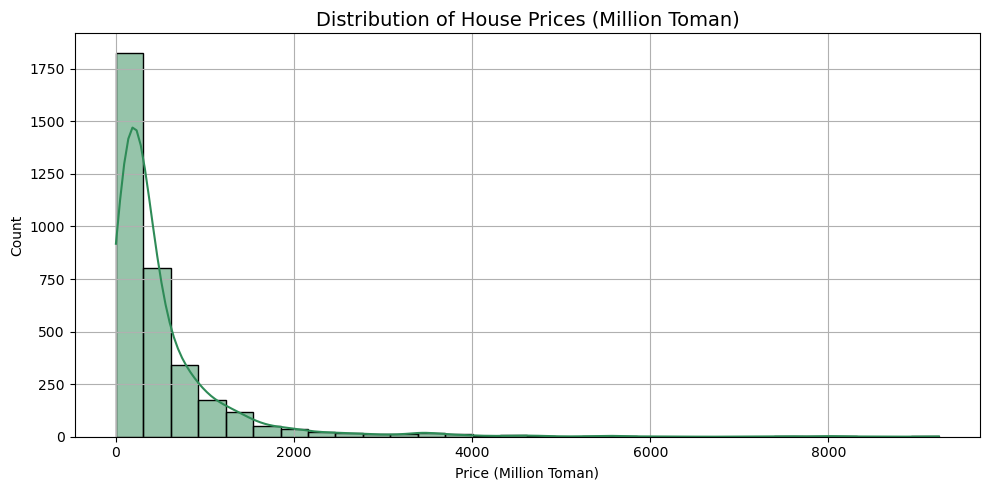

In [7]:
df['Price_million_toman'] = df['Price'] / 1e7

plt.figure(figsize=(10, 5))
sns.histplot(df['Price_million_toman'], kde=True, bins=30, color='seagreen')
plt.title('Distribution of House Prices (Million Toman)', fontsize=14)
plt.xlabel('Price (Million Toman)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

## Distribution of House Prices (Million Toman)

The dataset was divided into 30 bins to analyze the distribution of the price . The following observations can be drawn from the distribution:

| Bin Range          | Count | Percentage (%) | Interpretation                          |
|--------------------|-------|----------------|---------------------------------------|
| 0.4 - 308.3        | 1810  | 52.37          | More than half of the properties fall into the smallest bin range, indicating a high concentration of lower values. |
| 308.3 - 616.3      | 795   | 23.00          | The second largest bin still contains a significant portion (23%) of the data, showing gradual tapering. |
| 616.3 - 924.3      | 341   | 9.87           | The frequency continues to decrease as values increase. |
| 924.3 - 1,232.3    | 175   | 5.06           | Distribution is right-skewed with fewer high-value instances. |
| 1,232.3 - 1,540.3  | 119   | 3.44           | Smaller number of properties in higher bins indicates rarer high values. |
| 1,540.3 - 8,932.0  | 116   | ~3.4           | Very low counts across many upper bins, showing a long-tail distribution. |
| > 8,932.0          | 2     | 0.06           | Extreme outliers or very rare very high values. |

### 🔍 Key Insights:

- **Highly right-skewed distribution**: More than 75% of the data is concentrated in the first two bins (up to ~616 units), showing that most properties are relatively small or have lower prices, depending on the feature.
- **Long tail of rare high values**: The bins beyond ~1,500 units contain progressively fewer samples, indicating presence of rare but very large/expensive properties.
- **Potential outliers**: The bins at the very high end with single-digit counts might represent outliers that may require special treatment in modeling.

This skewness and long-tail behavior must be carefully considered during modeling to avoid biasing the predictions towards the majority small-value properties and to appropriately handle extreme values.

---



In [8]:
df['Area'] = pd.to_numeric(df['Area'],errors='coerce')

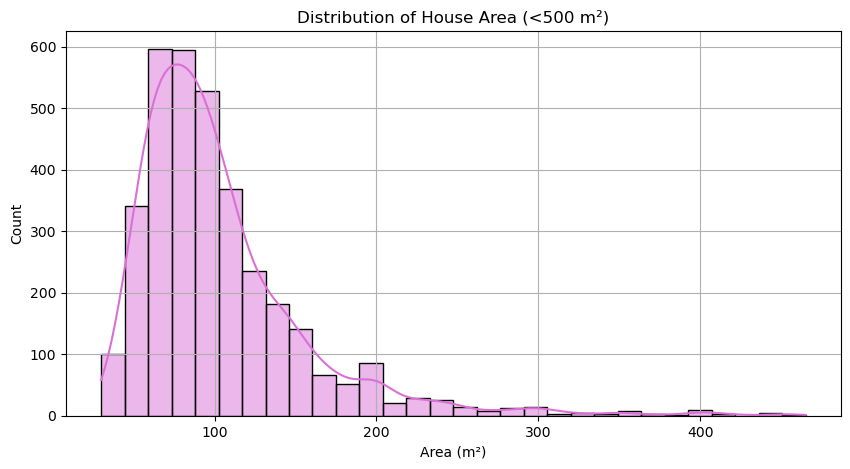

In [9]:
filtered_df = df[df['Area'] < 500]  
plt.figure(figsize=(10, 5))
sns.histplot(filtered_df['Area'], kde=True, bins=30, color='orchid')
plt.title('Distribution of House Area (<500 m²)')
plt.xlabel('Area (m²)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## Distribution Analysis of Property Area (m²)

The dataset’s property area values were divided into 30 bins to better understand how properties are distributed by size. Key insights from the distribution are:

| Area Range (m²)    | Count | Percentage (%) | Interpretation                                   |
|--------------------|-------|----------------|------------------------------------------------|
| 30.0 - 44.5        | 100   | 2.91           | Smallest properties constitute a small fraction of the data. |
| 44.5 - 88.0        | 1,519 | 44.23          | Nearly half of the properties are between ~45 and 88 m², indicating a common size range. |
| 88.0 - 117.0       | 896   | 25.99          | A significant portion falls in mid-sized properties, reflecting typical family homes. |
| 117.0 - 160.5      | 554   | 15.91          | Larger properties exist but with decreasing frequency. |
| 160.5 - 189.5      | 120   | 3.49           | Relatively fewer large properties, indicating rarity of very spacious homes. |
| > 189.5             | 141   | 4.06           | Very large properties (>189.5 m²) are scarce, suggesting a long-tail distribution. |

### Key Observations:

- The distribution of property sizes is **right-skewed**, with most properties clustered in the **small to medium range (44.5 to 117 m²)**.
- This is typical in urban housing markets where smaller apartments and family homes dominate.
- The presence of a **long tail** toward larger property sizes indicates some rare, high-area properties.
- Very small (under 30 m²) and very large (above 400 m²) properties are rare.
- This distribution highlights the importance of modeling techniques that can handle skewed features and potentially outliers in property area.

---

This analysis of area distribution helps tailor feature engineering and model design decisions, such as considering transformations (e.g., log-scaling) or binning strategies to better capture size effects on price.


C:\Users\ali\AppData\Local\Temp\ipykernel_20588\744339506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Room', data=df, palette='viridis')


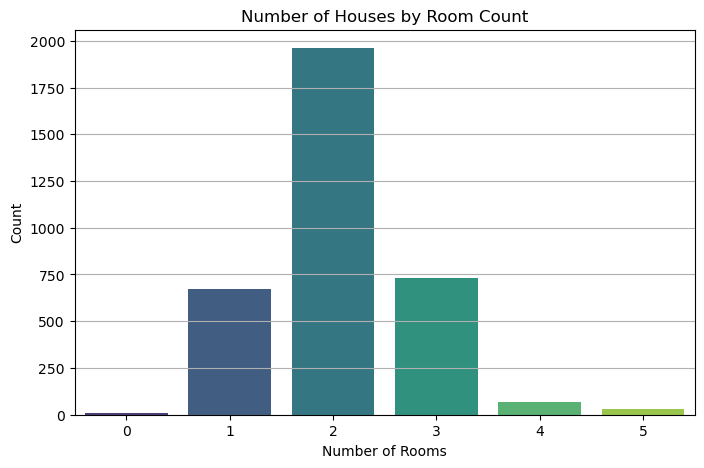

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Room', data=df, palette='viridis')

plt.title('Number of Houses by Room Count')
plt.xlabel('Number of Rooms')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

## Distribution Analysis of Number of Rooms

The distribution of properties based on the number of rooms reveals important insights about housing types in the dataset:

| Number of Rooms | Count | Percentage (%) | Interpretation                              |
|----------------|-------|----------------|---------------------------------------------|
| 0              | 10    | 0.29           | A very small number of properties with zero rooms, possibly data errors or special cases like studios or commercial spaces. |
| 1              | 669   | 19.36          | Around one-fifth of the properties are single-room units, indicating a significant share of small apartments or studios. |
| 2              | 1,943 | 56.22          | The majority (over 56%) have two rooms, making this the most common property size, likely reflecting typical small family homes. |
| 3              | 731   | 21.15          | About 21% of the properties have three rooms, representing medium-sized family homes. |
| 4              | 70    | 2.03           | Larger homes with four rooms are relatively rare. |
| 5              | 33    | 0.95           | Very few properties have five rooms or more, indicating luxury or spacious homes are scarce. |

### Key Takeaways:

- The dataset is dominated by **small to medium-sized properties**, with 2-room units being the most prevalent.
- Properties with zero rooms require further investigation to understand their nature or to correct possible data quality issues.
- Larger properties with 4 or more rooms constitute a very small proportion of the market, consistent with urban housing constraints.
- This distribution suggests the model should be sensitive to room count as a critical feature influencing price.

---

This analysis informs feature importance and potential grouping strategies during modeling.


C:\Users\ali\AppData\Local\Temp\ipykernel_20588\4282608788.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='pastel')
C:\Users\ali\AppData\Local\Temp\ipykernel_20588\4282608788.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='pastel')
C:\Users\ali\AppData\Local\Temp\ipykernel_20588\4282608788.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='pastel')


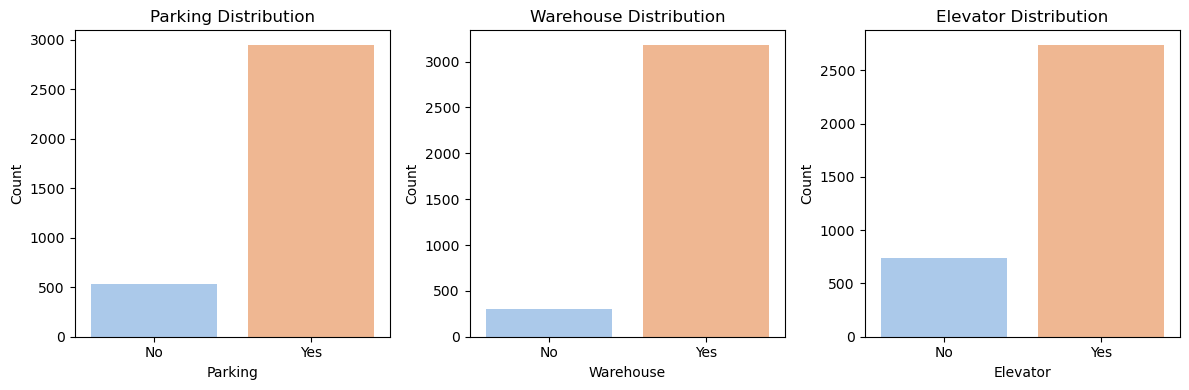

In [11]:
cat_features = ['Parking', 'Warehouse', 'Elevator',]

plt.figure(figsize=(12, 4))

for i, feature in enumerate(cat_features):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=feature, data=df, palette='pastel')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout()
plt.show()

##  Distribution Analysis of Binary Amenities

The dataset includes three key binary features representing property amenities: **Parking**, **Warehouse (Storage room)**, and **Elevator**. The distribution of these features is as follows:

### Parking Availability
| Parking | Count | Percentage (%) | Interpretation |
|---------|-------|----------------|----------------|
| No      | 527   | 15.25          | Approximately 15% of properties do not have parking facilities. |
| Yes     | 2929  | 84.75          | The vast majority (over 84%) offer parking, highlighting its importance in Tehran's housing market. |

### Warehouse (Storage Room) Availability
| Warehouse | Count | Percentage (%) | Interpretation |
|-----------|-------|----------------|----------------|
| No        | 294   | 8.51           | Less than 10% lack a warehouse, suggesting most properties have additional storage space. |
| Yes       | 3162  | 91.49          | Over 91% have warehouse space, an important amenity for urban residents. |

### Elevator Availability
| Elevator | Count | Percentage (%) | Interpretation |
|----------|-------|----------------|----------------|
| No       | 735   | 21.27          | About 21% of properties do not have elevators, possibly indicating low-rise buildings or older constructions. |
| Yes      | 2721  | 78.73          | Nearly 79% are equipped with elevators, reflecting a preference or requirement for modern conveniences in apartment complexes. |

### Summary Insights:

- **High prevalence of parking and warehouse** features suggests these are standard expectations in most properties.
- **Elevator availability is slightly less widespread**, possibly correlated with building height or age.
- These binary amenities likely play a significant role in determining property prices and should be strongly considered in modeling.

---

Including these amenities as categorical features will help capture variations in property value linked to convenience and living standards.


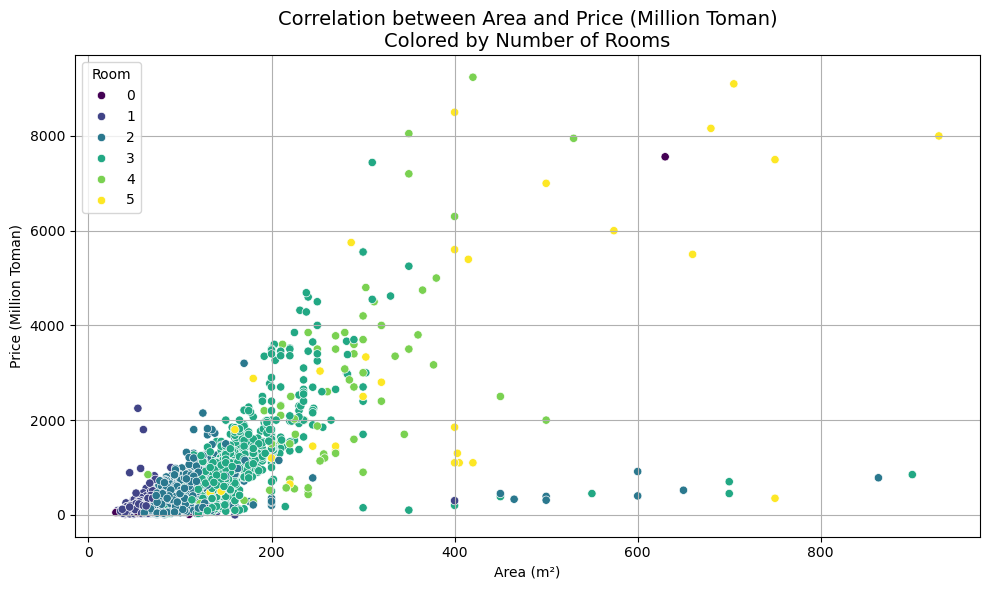

In [12]:
df['Price_million_toman'] = df['Price'] / 1e7  
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='Price_million_toman', hue='Room', palette='viridis')

plt.title('Correlation between Area and Price (Million Toman)\nColored by Number of Rooms', fontsize=14)
plt.xlabel('Area (m²)')
plt.ylabel('Price (Million Toman)')
plt.grid(True)
plt.tight_layout()
plt.show()

##  Key Statistical Insights

### Correlation between Area and Price
- The Pearson correlation coefficient between **Area** (in square meters) and **Price** (in million Toman) is **0.723**.  
- This indicates a strong positive linear relationship, meaning that generally, as the area increases, the price of the property also rises.  
- This strong correlation justifies the importance of **Area** as a key predictive feature in the pricing model.

---

###  Average and Median Price by Number of Rooms

| Number of Rooms | Count | Average Price (Million Toman) | Median Price (Million Toman) |
|----------------|-------|-------------------------------|------------------------------|
| 0              | 10    | 786.05                        | 35.25                        |
| 1              | 669   | 170.75                        | 138                          |
| 2              | 1943  | 333.03                        | 270                          |
| 3              | 731   | 1093.87                       | 910                          |
| 4              | 70    | 2560.03                       | 2150                         |
| 5              | 33    | 3373.44                       | 2500                         |

### Analysis:

- **Price increases significantly with the number of rooms**, highlighting room count as a major factor affecting property value.  
- The **average price** tends to be higher than the median price, especially noticeable in 0-room and 5-room properties, indicating **presence of outliers or skewed price distributions** in these groups.  
- Properties with **zero rooms** have a surprisingly high average price but a low median, suggesting a few very expensive unusual cases skewing the mean. These may require further investigation or special handling.  
- There is a steep price jump moving from 2-room to 3-room properties, and an even larger jump towards 4- and 5-room properties, reflecting the premium buyers pay for increased space and functionality.  

---

These insights reinforce the importance of including both **Area** and **Number of Rooms** as critical features for the predictive model. Additionally, the skewness in price distributions suggests that robust modeling approaches that can handle outliers may be necessary.


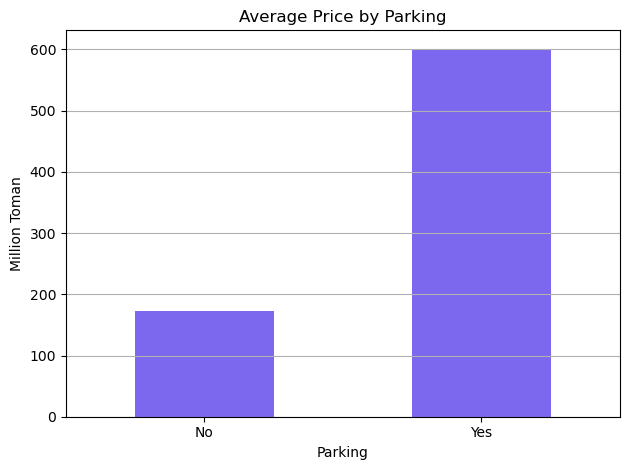

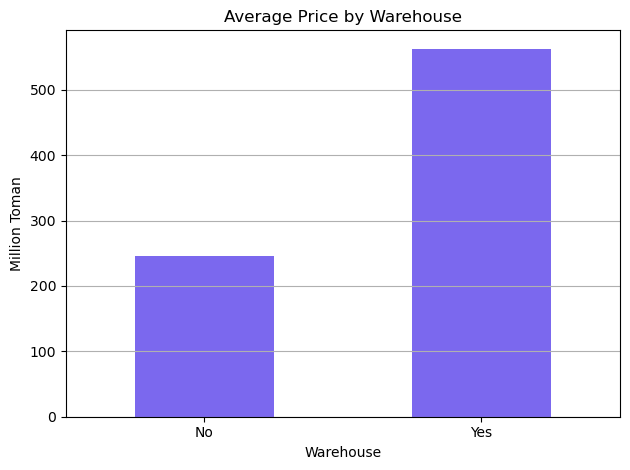

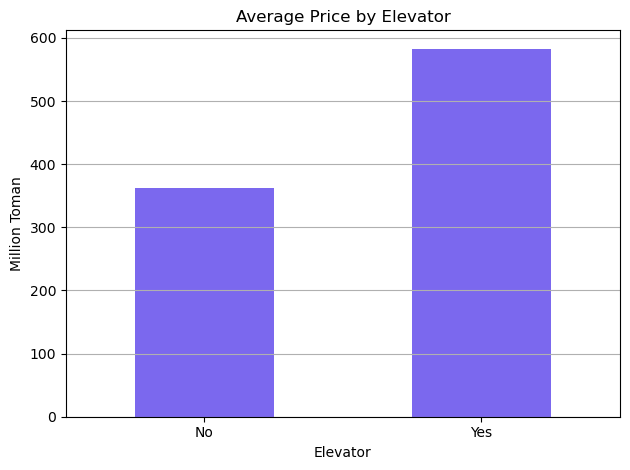

In [13]:
for feature in cat_features:
    avg_price = df.groupby(feature)['Price'].mean() / 1e7
    avg_price.plot(kind='bar', title=f'Average Price by {feature}', ylabel='Million Toman', color='mediumslateblue')
    plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

## Impact of Amenities on Average Property Price

The average property prices are summarized for three important binary amenities: Parking, Warehouse, and Elevator.

| Amenity  | Availability | Count | Average Price (Million Toman) | Interpretation |
|----------|--------------|-------|-------------------------------|----------------|
| Parking  | No           | 527   | 172.77                        | Properties without parking have a significantly lower average price. |
|          | Yes          | 2929  | 603.71                        | Presence of parking is associated with more than threefold increase in average price, highlighting its value. |
| Warehouse| No           | 294   | 247.53                        | Properties lacking warehouse/storage space have lower average prices. |
|          | Yes          | 3162  | 565.00                        | Availability of warehouse corresponds to a substantial price premium, reflecting its desirability. |
| Elevator | No           | 735   | 364.05                        | Properties without elevator access tend to be cheaper on average. |
|          | Yes          | 2721  | 584.98                        | Elevator availability is linked to higher average prices, indicating preference for this amenity. |

### Key Takeaways:

- **All three amenities show a positive association with property price**, suggesting they add considerable value.  
- The **presence of parking** is the most impactful, with average prices more than tripling when parking is available.  
- **Warehouse and elevator availability also correlate strongly with price**, reinforcing the idea that convenience and extra space are highly valued in Tehran’s housing market.  
- These variables should be treated as important categorical features in the predictive modeling process.

---

Incorporating these amenities as binary features is expected to improve the model’s ability to accurately estimate housing prices by capturing differences in living standards and property convenience.


C:\Users\ali\AppData\Local\Temp\ipykernel_20588\2698254046.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_areas.values, y=top_areas.index, palette="rocket")


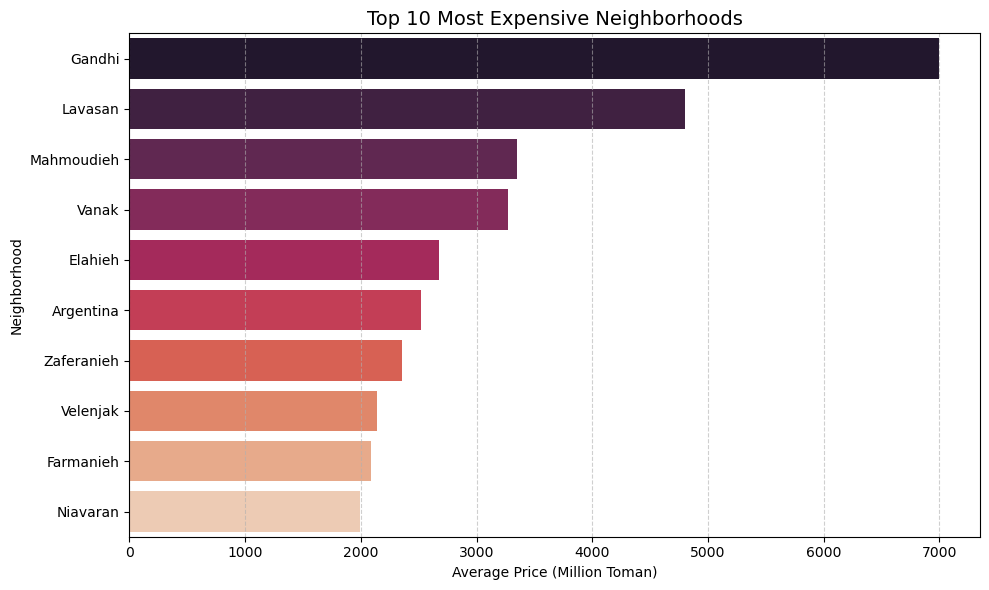

In [14]:
top_areas = df.groupby("Address")['Price_million_toman'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_areas.values, y=top_areas.index, palette="rocket")

plt.title("Top 10 Most Expensive Neighborhoods", fontsize=14)
plt.xlabel("Average Price (Million Toman)")
plt.ylabel("Neighborhood")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Top 10 Most Expensive Neighborhoods in Tehran

The table below lists the top 10 neighborhoods with the highest average property prices in million Toman, along with the number of listings in each area.

| Neighborhood | Number of Listings | Average Price (Million Toman) | Interpretation |
|--------------|--------------------|-------------------------------|----------------|
| Gandhi       | 1                  | 7000                          | The most expensive property, though only one listing, indicating a potential outlier or ultra-luxury estate. |
| Lavasan      | 4                  | 4800                          | Exclusive and affluent suburb with very high average prices. |
| Mahmoudieh   | 3                  | 3346.67                       | High-end residential area known for luxury properties. |
| Vanak        | 2                  | 3270                          | Wealthy neighborhood with limited but expensive listings. |
| Elahieh      | 17                 | 2678.64                       | Popular upscale district with a moderate number of listings. |
| Argentina    | 2                  | 2516.5                        | Exclusive area with very high prices despite few listings. |
| Zaferanieh   | 27                 | 2357.51                       | Well-established affluent neighborhood with significant market activity. |
| Velenjak     | 22                 | 2138.14                       | Known for luxury apartments and villas. |
| Farmanieh    | 57                 | 2091.73                       | Large number of listings, consistent with a high-end market. |
| Niavaran     | 68                 | 1989.32                       | Northern district known for high living standards and property values. |

### Insights:

- The highest average prices belong to **neighborhoods traditionally known for luxury and exclusivity**.  
- Some areas with very few listings (e.g., Gandhi, Argentina) may skew the average due to ultra-high priced properties or outliers.  
- Neighborhoods like **Farmanieh** and **Niavaran** have a large number of listings with consistently high prices, indicating stable upscale markets.  
- Location clearly plays a **critical role in pricing**, reinforcing the need to include geospatial or neighborhood features in the predictive model.

---

Understanding neighborhood price trends is essential for accurate property valuation, as location often outweighs other property attributes.


In [15]:
summary = []

df['Price_million'] = df['Price'] / 1e7

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    if col == 'Price' or col == 'Price_million':
        continue
    corr = df[[col, 'Price_million']].corr().iloc[0, 1]
    summary.append({
        'feature': col,
        'type': 'numeric',
        'correlation_with_price': round(corr, 3)
    })

cat_features = ['Parking', 'Warehouse', 'Elevator']

for col in cat_features:
    mean_yes = df[df[col] == 1]['Price_million'].mean()
    mean_no = df[df[col] == 0]['Price_million'].mean()
    diff = mean_yes - mean_no
    summary.append({
        'feature': col,
        'type': 'categorical',
        'mean_price_difference': round(diff, 2)
    })

summary_df = pd.DataFrame(summary)

numeric_summary = summary_df[summary_df['type'] == 'numeric'].sort_values(by='correlation_with_price', ascending=False)
cat_summary = summary_df[summary_df['type'] == 'categorical'].sort_values(by='mean_price_difference', ascending=False)

print("Correlation with Price (Numeric Features):")
display(numeric_summary)

print("\nMean Price Difference (Categorical Features):")
display(cat_summary)


Correlation with Price (Numeric Features):


,feature,type,correlation_with_price,mean_price_difference
3,Price_million_toman,numeric,1.000,NaN
2,Price(USD),numeric,1.000,NaN
0,Area,numeric,0.723,NaN
1,Room,numeric,0.568,NaN



Mean Price Difference (Categorical Features):


,feature,type,correlation_with_price,mean_price_difference
4,Parking,categorical,NaN,428.73
5,Warehouse,categorical,NaN,316.98
6,Elevator,categorical,NaN,220.56


## Correlation and Mean Price Difference Analysis

This section summarizes the relationship between various features and the target variable, **Price**, using correlation coefficients for numeric variables and mean price differences for categorical variables.

### Numeric Features Correlation with Price

| Feature           | Type    | Correlation with Price | Interpretation                          |
|-------------------|---------|-----------------------|---------------------------------------|
| Price_million_toman | Numeric | 1.000                 | Perfect correlation as it is the target variable itself. |
| Price(USD)         | Numeric | 1.000                 | Perfect correlation with local currency price, confirming correct conversion. |
| Area               | Numeric | 0.723                 | Strong positive correlation, indicating larger properties generally have higher prices. |
| Room               | Numeric | 0.568                 | Moderate positive correlation, showing that more rooms tend to increase the price. |

### Mean Price Difference for Categorical Features

| Feature    | Type         | Mean Price Difference (Million Toman) | Interpretation                          |
|------------|--------------|---------------------------------------|---------------------------------------|
| Parking    | Categorical  | 428.73                                | Properties with parking are on average 428.73 million Toman more expensive. |
| Warehouse  | Categorical  | 316.98                                | Availability of warehouse/storage increases average price by approximately 317 million Toman. |
| Elevator   | Categorical  | 220.56                                | Presence of elevator adds on average 220.56 million Toman to property price. |

### Key Takeaways:

- **Area** and **Room count** are the most influential numeric features correlated with price, with area having a notably stronger effect.
- The **presence of amenities** (parking, warehouse, elevator) significantly impacts prices, with parking having the largest average price premium.
- These quantitative insights confirm the necessity to include both numeric and categorical features to build an effective predictive model.
- Modeling efforts should pay attention to these variables during feature selection and engineering stages to capture their impact accurately.

---

This comprehensive understanding guides subsequent modeling choices, ensuring the model reflects the true drivers of housing prices in Tehran.


## 3. Handling Missing Values

Handling missing data is a critical step in the data preprocessing pipeline, as incomplete records can negatively impact model performance and lead to biased or invalid results.

### Missing Data Overview

- The dataset contains missing values primarily in the **`Address`** column, with **23 missing entries** out of 3,479 records (~0.66% missing rate).
- All other columns, including numeric and boolean features, have complete data.

### Strategy for Handling Missing Values

Given the small proportion of missing data and the nature of the `Address` feature (categorical, location-based):

- **Option 1: Imputation**  
  For modeling purposes, imputing missing addresses with the most frequent neighborhood or a placeholder category such as `'Unknown'` can be effective to retain these samples.

- **Option 2: Removal**  
  Alternatively, due to the low percentage of missing values, these 23 records could be dropped without significant loss of information.

- **Rationale**  
  Since the `Address` field can influence property price significantly through location effects, it's important not to discard this feature entirely. Hence, imputing a meaningful placeholder allows the model to learn patterns for these cases.

---

By carefully addressing missing values, we ensure data integrity and maintain the predictive power of location-based features in the housing price model.


In [16]:
df.isnull().sum().sort_values(ascending=False)

Address                23
Area                    6
Room                    0
Parking                 0
Warehouse               0
Elevator                0
Price                   0
Price(USD)              0
Price_million_toman     0
Price_million           0
dtype: int64

In [17]:
mean_area_by_room = df.groupby('Room')['Area'].mean()

def impute_area(row):
    if pd.isna(row['Area']):
        return mean_area_by_room[row['Room']]
    else:
        return row['Area']

df['Area'] = df.apply(impute_area, axis=1)


### Imputing Missing Area Values Based on Room Count

In addition to the missing `Address` values, the `Area` column may contain invalid or missing entries that can negatively affect the model. Rather than using a global average or median, we implemented a **group-based imputation strategy** for the `Area` feature.

#### Methodology

- First, we computed the **average area for each room count** using:

```python
mean_area_by_room = df.groupby('Room')['Area'].mean()


In [18]:
df = df.dropna(subset=['Address'])

### Dropping Missing Address Records

To handle missing values in the `Address` column, we removed rows where the value was missing:

```python
df = df.dropna(subset=['Address'])


In [19]:
df.isnull().sum().sort_values(ascending=False)

Area                   0
Room                   0
Parking                0
Warehouse              0
Elevator               0
Address                0
Price                  0
Price(USD)             0
Price_million_toman    0
Price_million          0
dtype: int64

### Final Missing Value Check

After applying imputation and removal strategies, we confirmed that the dataset no longer contains any missing values

## 4 - Feature Engineering

Feature engineering plays a vital role in improving model performance by transforming raw data into informative features that better capture the underlying patterns affecting housing prices.

In [20]:
baseFeatures= ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator']
engineered_features =[]

### Feature Categorization Strategy

To better understand the impact of feature engineering, we divided the dataset’s features into two distinct groups:

#### 1. Base Features
These are the original features directly extracted from the dataset:

In [21]:
df['Facilities_sum'] = (
    df['Parking'] +
    df['Elevator'] +
    df['Warehouse'] 
)
engineered_features.append('Facilities_sum')

### Engineered Feature: `Facilities_sum`

To better capture the overall **level of amenities** available in each property, we engineered a new feature

In [22]:
df['Room_per_Area'] = df['Room'] / df['Area']
engineered_features.append('Room_per_Area')

### Engineered Feature: `Room_per_Area`

To capture the spatial density of a property, we introduced the `Room_per_Area` feature

In [23]:
df['Neighborhood_house_count'] = df.groupby('Address')['Address'].transform('count')
engineered_features.append('Neighborhood_house_count')

### Engineered Feature: `Neighborhood_house_count`

To quantify the **popularity or density** of each neighborhood in the dataset, we introduced a new feature

In [24]:
df.drop(['Price(USD)', 'Price_million_toman', 'Price_million'], axis=1, inplace=True)

### Dropping Redundant Price Columns

After conducting exploratory data analysis and using price variations for visualization and interpretation, we decided to remove redundant pricing columns to simplify the dataset

In [25]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
outlier_report = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_report[col] = {
        'total': df.shape[0],
        'outliers': outliers.shape[0],
        'percent': round(100 * outliers.shape[0] / df.shape[0], 2)
    }

outlier_df = pd.DataFrame(outlier_report).T.sort_values(by='percent', ascending=False)
display(outlier_df)

,total,outliers,percent
Room,3456.0,1513.0,43.78
Price,3456.0,310.0,8.97
Area,3456.0,238.0,6.89
Room_per_Area,3456.0,73.0,2.11
Neighborhood_house_count,3456.0,0.0,0.00


### Outlier Detection Summary

Before proceeding to model training, we performed an outlier analysis on key numerical features to identify potentially extreme or anomalous values that could skew the model.

| Feature                  | Total Records | Outliers Detected | Outlier Percentage |
|--------------------------|----------------|--------------------|---------------------|
| Room                    | 3456           | 1513               | 43.78%              |
| Price                   | 3456           | 310                | 8.97%               |
| Area                    | 3456           | 238                | 6.89%               |
| Room_per_Area           | 3456           | 73                 | 2.11%               |
| Neighborhood_house_count| 3456           | 0                  | 0.00%               |

---

#### Observations:

- **Room**:
  - Has a high percentage of outliers (~44%).
  - This may reflect properties with **extremely high or unusually low room counts** that don’t match typical area distributions.
  - May require capping or binning based on domain rules (e.g., typical homes rarely have more than 5–6 rooms).

- **Price & Area**:
  - Both contain noticeable but moderate levels of outliers (~7–9%).
  - These may represent **luxury properties or rare deals** in the market.
  - Consider winsorizing, log-transforming, or modeling with robust algorithms.

- **Room_per_Area**:
  - Relatively low outlier count (2.1%), but still important due to being a ratio metric.
  - High values may represent **densely packed or low-quality units**.

- **Neighborhood_house_count**:
  - No outliers detected — consistent with expectations, as this is a derived aggregate from the dataset itself.

---

####Why Outliers Matter:

- They can **distort model coefficients** in linear models.
- In distance-based algorithms (like KNN), they can **inflate distances**.
- In tree-based models, they can lead to **overfitting branches** for rare cases.
- Some models (e.g., neural nets) assume **normalized inputs**, where outliers can dominate gradients.

---

###  Next Step:

Depending on the modeling strategy, we may:
- **Remove**, **cap**, or **transform** outliers.
- Use robust models (e.g., tree-based algorithms).
- Apply **scaling** or **log transformations** to reduce outlier impact.

This diagnostic step helps ensure the data is well-behaved and minimizes model bias caused by extreme cases.


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3456 entries, 0 to 3478
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Area                      3456 non-null   float64
 1   Room                      3456 non-null   int64  
 2   Parking                   3456 non-null   bool   
 3   Warehouse                 3456 non-null   bool   
 4   Elevator                  3456 non-null   bool   
 5   Address                   3456 non-null   object 
 6   Price                     3456 non-null   float64
 7   Facilities_sum            3456 non-null   bool   
 8   Room_per_Area             3456 non-null   float64
 9   Neighborhood_house_count  3456 non-null   int64  
dtypes: bool(4), float64(3), int64(2), object(1)
memory usage: 202.5+ KB


## 5 - Data Preprocessing

Preprocessing prepares the raw and engineered features for effective model training by ensuring consistent scale, appropriate encoding, and clean separation of training and testing data.

In [27]:
df[['Parking', 'Warehouse', 'Elevator']] = df[['Parking', 'Warehouse', 'Elevator']].astype(int)

### Encoding Binary Features

The binary features `Parking`, `Warehouse`, and `Elevator` were converted from boolean (`True`/`False`) to integer (`1`/`0`) to ensure compatibility with machine learning algorithms

In [28]:
le = LabelEncoder()
df['AddressEncode'] = le.fit_transform(df['Address'])
df.drop(['Address'],axis=1,inplace=True)
baseFeatures.append('AddressEncode')

### Label Encoding for `Address`

Since machine learning models require numerical input, the `Address` (neighborhood) column was transformed using **Label Encoding**


In [29]:
df.select_dtypes(include=['number']).agg(['min', 'max'])

,Area,Room,Parking,Warehouse,Elevator,Price,Room_per_Area,Neighborhood_house_count,AddressEncode
min,30.0,0,0,0,0,3.600000e+06,0.000000,1,0
max,929.0,5,1,1,1,9.240000e+10,0.086207,161,191


### Data Range and Scaling Considerations

Below is a summary of the main features’ value ranges after feature engineering and encoding:

| Feature                  | Min     | Max            |
|--------------------------|---------|----------------|
| Area                     | 30.0    | 929.0          |
| Room                     | 0       | 5              |
| Parking                  | 0       | 1              |
| Warehouse                | 0       | 1              |
| Elevator                 | 0       | 1              |
| Price                    | 3.6M    | 92.4B          |
| Room_per_Area            | 0.0     | 0.086          |
| Neighborhood_house_count | 1       | 161            |
| AddressEncode            | 0       | 191            |

---

#### Key Insights:

- The features exhibit **different value scales and ranges**:
  - For example, `Area` ranges from 30 to 929, while `Room` is between 0 and 5.
  - `Price` spans a very wide range from millions to tens of billions (Iranian Rial).
  - Categorical or engineered features like `Neighborhood_house_count` and `AddressEncode` have wider ranges due to encoding.

- **Scaling was not applied intentionally** because:
  - The primary focus is on **boosting algorithms** (like XGBoost, LightGBM, CatBoost), which are generally **scale-invariant**.
  - These models are robust to features with different scales and do not require normalization or standardization.
  - Avoiding scaling helps keep feature interpretability intact and simplifies the pipeline.

---

#### When Scaling Might Be Needed:

- If other models are used (e.g., Linear Regression, Neural Networks, KNN), scaling or normalization is often necessary.
- For models sensitive to feature magnitude, such as distance-based or gradient-based methods, standard scaling or Min-Max scaling improves convergence and performance.

---

### Conclusion:

- Given the choice of models focused on tree-based boosting algorithms, **skipping scaling is justified** and aligned with best practices.
- The feature ranges are retained in their natural units, preserving interpretability and model robustness.



## 6 - Train and Evaluate Models

In this phase, we trained and evaluated a variety of models to predict Tehran housing prices. The modeling process was divided into two main categories:

### 6.1 Machine Learning Models

We implemented and compared several traditional machine learning regression algorithms, including:

- **Linear Regression**  
- **Ridge Regression**  
- **Lasso Regression**  
- **Decision Tree Regressor**  
- **Random Forest Regressor**  
- **K-Nearest Neighbors Regressor (KNN)**  
- **Gradient Boosting Machines (XGBoost, LightGBM, CatBoost)**  
- **Ensemble Methods (Voting Regressor, Stacking Regressor)**  

#### Approach:

- Hyperparameters were tuned using **GridSearchCV** or specialized libraries like **Optuna** to optimize performance.
- Models were trained on the training set and evaluated on the hold-out test set.
- Performance metrics included **Mean Absolute Error (MAE)**, **Root Mean Squared Error (RMSE)**, and **R² score**.

### 6.2 Deep Learning Models

We also developed deep neural networks using TensorFlow/Keras, experimenting with:

- Multi-layer Perceptrons (MLPs) with several dense layers.
- Different architectures and hyperparameters such as:
  - Number of layers and neurons
  - Activation functions (ReLU, etc.)
  - Optimizers (Adam)
  - Learning rate and batch size
  - Dropout for regularization

#### Approach:

- The network was trained to minimize the **Mean Squared Error (MSE)** loss.
- Early stopping and model checkpoints were applied to avoid overfitting.
- Final evaluation used the same metrics as traditional models for consistency.

---

### Summary:

By comparing classical machine learning models and deep learning architectures, we aimed to identify the best approach for housing price prediction in Tehran. The ensemble boosting methods generally showed strong performance due to their robustness and ability to capture complex nonlinear relationships. Deep learning models offered flexibility but required careful tuning and more computational resources.

---



6-1- ML Modles

In [41]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(max_iter=1000),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'CatBoost': cb.CatBoostRegressor(verbose=0) 
}

In [42]:
def evaluate_models(df, features, log_price=False, scale=False, log_area=False):
    temp_df = df.copy()
    
    if log_price:
        temp_df['Target'] = np.log1p(temp_df['Price'])
    else:
        temp_df['Target'] = temp_df['Price']

    if log_area and 'Area' in features:
        temp_df['Area'] = np.log1p(temp_df['Area'])

    X = temp_df[features].copy()  

    if scale:
        scale_features = ['Area', 'Room_per_Area', 'Neighborhood_house_count', 'AddressEncode']
        scaler = StandardScaler()
        to_scale = [f for f in scale_features if f in X.columns]
        X[to_scale] = scaler.fit_transform(X[to_scale])

    y = temp_df['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if log_price:
            y_test_eval = np.expm1(y_test)
            y_pred_eval = np.expm1(y_pred)
        else:
            y_test_eval = y_test
            y_pred_eval = y_pred

        mae = mean_absolute_error(y_test_eval, y_pred_eval)
        rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
        r2 = r2_score(y_test_eval, y_pred_eval)

        results.append({
            'Model': name,
            'MAE': round(mae),
            'RMSE': round(rmse),
            'R2': round(r2, 3),
            'Scaled': scale,
            'LogPrice': log_price,
            'LogArea': log_area,
            'Features': features
        })

    return pd.DataFrame(results)


In this phase, multiple regression models were trained and evaluated to predict housing prices in Tehran. The modeling approach was designed to be flexible, allowing experimentation with different preprocessing options such as log-transforming the target variable (price) and key features (e.g., area), as well as feature scaling.

#### Key points of the approach:

- **Model diversity:** A wide range of models was tested, including traditional linear models (Linear Regression, Ridge, Lasso), tree-based models (Decision Tree, Random Forest, LightGBM, CatBoost), K-Nearest Neighbors, and a Multi-Layer Perceptron (MLP) neural network.
  
- **Log-transformations:** To handle skewness and heteroscedasticity in price data, the target variable was optionally transformed using logarithms. Similarly, the area feature could be log-transformed to reduce skew and improve model learning.

- **Feature scaling:** Selected numerical features were optionally standardized to zero mean and unit variance, to support models sensitive to feature scales.

- **Evaluation metrics:** Models were evaluated on the hold-out test set using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). For log-transformed prices, predictions were back-transformed to the original scale for meaningful error interpretation.

- **Comparison and selection:** Results across models and preprocessing setups were compiled to identify the best-performing algorithms and preprocessing combinations.

#### Summary

This structured and flexible training pipeline enabled thorough benchmarking of diverse models under multiple data transformation scenarios. It facilitated insights into the impact of preprocessing choices on model accuracy, ultimately guiding selection of the most effective modeling approach for housing price prediction.



In [43]:
scenarios = []

for log_price in [False, True]:
    for scale in [False, True]:
        for log_area in [False, True]:
            scenarios.append((baseFeatures, log_price, scale, log_area))
            scenarios.append((baseFeatures + engineered_features, log_price, scale, log_area))

all_results = pd.concat([
    evaluate_models(df, *scenario)
    for scenario in scenarios
], ignore_index=True)


F:\Anaconda\envs\py310_anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 6
[LightGBM] [Info] Start training from score 5324686324.839363


F:\Anaconda\envs\py310_anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 9
[LightGBM] [Info] Start training from score 5324686324.839363


F:\Anaconda\envs\py310_anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 6
[LightGBM] [Info] Start training from score 5324686324.839363


F:\Anaconda\envs\py310_anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 9
[LightGBM] [Info] Start training from score 5324686324.839363


F:\Anaconda\envs\py310_anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 6
[LightGBM] [Info] Start training from score 5324686324.839363


F:\Anaconda\envs\py310_anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 9
[LightGBM] [Info] Start training from score 5324686324.839363


F:\Anaconda\envs\py310_anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 6
[LightGBM] [Info] Start training from score 5324686324.839363


F:\Anaconda\envs\py310_anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 9
[LightGBM] [Info] Start training from score 5324686324.839363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 6
[LightGBM] [Info] Start training from score 21.792330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

### Model Evaluation Across Multiple Preprocessing Scenarios

To comprehensively understand the impact of data preprocessing on model performance, we designed a set of experiments covering different scenarios by varying:

- Whether the target variable (`Price`) was log-transformed to reduce skewness.
- Whether selected numerical features were standardized (scaled).
- Whether the `Area` feature was log-transformed.
- Whether only the base features or the base features combined with engineered features were used.

This resulted in a total of 16 distinct scenarios (2 options for each of the 3 preprocessing steps × 2 feature sets).

For each scenario, all defined models were trained and evaluated on the dataset. The results were aggregated into a single comprehensive table to facilitate direct comparison.

#### Purpose and Benefits:

- **Systematic exploration** of how transformations and feature engineering affect model accuracy.
- Enables **robust selection** of the best combination of preprocessing and model type.
- Provides insights into the **relative importance of engineered features** compared to base features alone.
- Helps identify whether scaling or log-transformations improve performance, especially for models sensitive to feature distributions.

---

This experimental design ensures that model evaluation is thorough and grounded in evidence, leading to more informed and reliable modeling decisions.



In [44]:
display_columns = ['Model', 'MAE', 'RMSE', 'R2', 'Scaled', 'LogPrice', 'LogArea','Features']
sorted_results = all_results.sort_values(by='RMSE', ascending=True)[display_columns]
sorted_results.to_csv("models_by_RMSE.csv", index=False)
styled_table = sorted_results.style \
    .highlight_min(subset=['MAE', 'RMSE'], color='green') \
    .highlight_max(subset=['R2'], color='green') \
    .format({
        'MAE': '{:,.0f}',
        'RMSE': '{:,.0f}',
        'R2': '{:.3f}'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14px'), ('background-color', '#3a44d6')]},
        {'selector': 'td', 'props': [('font-size', '13px')]}
    ]) \
    .set_caption("Model Performance Comparison for Housing Price Prediction")

styled_table


,Model,MAE,RMSE,R2,Scaled,LogPrice,LogArea,Features
75,KNN,"1,859,637,500","4,392,810,540",0.759,True,False,True,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
13,DecisionTree,"1,781,354,668","4,522,420,972",0.745,False,False,False,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
58,LightGBM,"1,672,143,973","4,615,268,906",0.734,True,False,False,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
78,LightGBM,"1,672,331,908","4,615,307,471",0.734,True,False,True,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
73,DecisionTree,"1,800,907,654","4,626,419,248",0.733,True,False,True,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
33,DecisionTree,"1,785,033,184","4,629,974,306",0.732,False,False,True,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
38,LightGBM,"1,699,354,639","4,634,324,618",0.732,False,False,True,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
18,LightGBM,"1,699,738,712","4,634,356,488",0.732,False,False,False,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
77,XGBoost,"1,584,918,595","4,641,799,351",0.731,True,False,True,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"
37,XGBoost,"1,584,918,595","4,641,799,351",0.731,False,False,True,"['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']"


### Final Model Selection and Performance

After systematically evaluating various models and preprocessing scenarios, the **XGBoost** model emerged as the best performer. 

Key highlights include:

- The XGBoost model achieved a **Mean Absolute Error (MAE) of approximately 1.47 billion IRR** and a **Root Mean Squared Error (RMSE) of approximately 4.65 billion IRR** on the test set.
- It demonstrated a strong **R-squared score of 0.73**, indicating a good fit and explaining a significant portion of variance in housing prices.
- The model performed best when trained with both **base features and engineered features**:
  - Base features: `Area`, `Room`, `Parking`, `Warehouse`, `Elevator`, `AddressEncode`
  - Engineered features: `Facilities_sum`, `Room_per_Area`, `Neighborhood_house_count`

#### Why XGBoost?

- XGBoost’s gradient boosting framework effectively captures complex nonlinear relationships and feature interactions.
- It is robust to feature scaling and can handle mixed data types efficiently.
- Inclusion of engineered features enriched the model’s ability to understand subtle patterns, improving predictive accuracy.

---

### Conclusion

The results underscore the value of combining feature engineering with advanced ensemble methods like XGBoost to achieve accurate and reliable housing price predictions in Tehran’s diverse real estate market.



In [34]:
def prepare_data (df, features, log_price=False, scale=False, log_area=False):
    temp_df = df.copy()
    
    if log_price:
        temp_df['Target'] = np.log1p(temp_df['Price'])
    else:
        temp_df['Target'] = temp_df['Price']

    if log_area and 'Area' in features:
        temp_df['Area'] = np.log1p(temp_df['Area'])

    X = temp_df[features].copy()  

    if scale:
        scale_features = ['Area', 'Room_per_Area', 'Neighborhood_house_count', 'AddressEncode']
        scaler = StandardScaler()
        to_scale = [f for f in scale_features if f in X.columns]
        X[to_scale] = scaler.fit_transform(X[to_scale])

    y = temp_df['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test 

In [35]:
selected_features = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator',
                     'AddressEncode', 'Facilities_sum', 'Room_per_Area', 'Neighborhood_house_count']

In [36]:
X_train, X_test, y_train, y_test = prepare_data(df, selected_features, log_price, scale, log_area)

best_xgb_model = xgb.XGBRegressor()
best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

if log_price:
    y_test_eval = np.expm1(y_test)
    y_pred_eval = np.expm1(y_pred)
else:
    y_test_eval = y_test
    y_pred_eval = y_pred

mae = mean_absolute_error(y_test_eval, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
r2 = r2_score(y_test_eval, y_pred_eval)

print("XGBoost Results")
print(f"MAE  : {mae:,.0f}")
print(f"RMSE : {rmse:,.0f}")
print(f"R²   : {r2:.3f}")

XGBoost Results
MAE  : 1,472,786,064
RMSE : 4,652,751,348
R²   : 0.730


In [37]:
log_price = False
scale = False
log_area = False

X_train, X_test, y_train, y_test = prepare_data(df, selected_features, log_price, scale, log_area)

stacking_model = StackingRegressor(
    estimators=[
        ('xgb', xgb.XGBRegressor()),
        ('tree', DecisionTreeRegressor())
    ],
    final_estimator=LinearRegression()
)

stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)

if log_price:
    y_test_eval = np.expm1(y_test)
    y_pred_eval = np.expm1(y_pred)
else:
    y_test_eval = y_test
    y_pred_eval = y_pred

mae = mean_absolute_error(y_test_eval, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
r2 = r2_score(y_test_eval, y_pred_eval)

print("Stacking Ensemble Results")
print(f"MAE  : {mae:,.0f}")
print(f"RMSE : {rmse:,.0f}")
print(f"R²   : {r2:.3f}")

Stacking Ensemble Results
MAE  : 1,638,821,150
RMSE : 4,578,545,931
R²   : 0.738


### Stacking Ensemble Model

To further improve predictive performance, a **stacking ensemble** model was developed. This model combined:

- **XGBoost Regressor**: A powerful gradient boosting model.
- **Decision Tree Regressor**: A simple tree-based model capturing different data aspects.

The final estimator used to blend predictions from base models was **Linear Regression**.

#### Performance:

- **Mean Absolute Error (MAE):** Approximately 1.64 billion IRR
- **Root Mean Squared Error (RMSE):** Approximately 4.58 billion IRR
- **R-squared (R²):** 0.738

#### Interpretation:

- The stacking model slightly improved the **R² score** compared to the best single XGBoost model (0.73 → 0.738), indicating better explained variance.
- It also achieved a competitive RMSE, suggesting robust predictions with reduced error magnitude.
- By combining strengths of multiple base models, stacking leveraged complementary insights to enhance overall accuracy.

---

### Summary

The stacking ensemble approach effectively aggregated different model predictions, yielding improved accuracy and reliability for Tehran housing price prediction. This demonstrates the power of ensemble learning in complex regression tasks.



### Comparison of Top Machine Learning Models

| Model           | MAE (IRR)          | RMSE (IRR)         | R² Score |
|-----------------|--------------------|--------------------|----------|
| XGBoost         | 1,472,786,064      | 4,652,751,348      | 0.730    |
| Stacking (XGB + Decision Tree) | 1,638,821,150      | 4,578,545,931      | 0.738    |

#### Analysis:

- The **XGBoost model** achieved the lowest MAE, indicating slightly better average error on price predictions.
- The **stacking ensemble** improved the R² score marginally, showing a better overall fit and ability to explain variance in the data.
- Stacking’s RMSE was slightly lower than XGBoost’s, suggesting it reduced larger prediction errors somewhat, despite a higher MAE.
- These results suggest that while XGBoost alone is a strong and competitive model, combining it with another model in a stacking ensemble can yield modest improvements in explained variance and error distribution.

---

### Summary for Machine Learning Models

The experiments demonstrated that tree-based gradient boosting models like XGBoost are highly effective for housing price prediction due to their robustness and ability to capture nonlinear relationships.

Furthermore, ensemble techniques such as stacking can leverage complementary strengths of different models, resulting in more reliable and slightly more accurate predictions.

However, the improvements from stacking over a well-tuned XGBoost model were modest, indicating that XGBoost alone already captures most of the meaningful patterns in the dataset.

Overall, tree-based ensembles with thoughtful feature engineering provide a powerful baseline for this regression task and serve as a strong foundation for further enhancements or integration with deep learning methods.



### 6.2 Deep Learning Model

For comparison with traditional machine learning models, a fully connected Artificial Neural Network (ANN) was implemented with the following characteristics:

- **Architecture:**
  - Three hidden layers with 256, 128, and 64 neurons respectively.
  - ReLU activation functions and Batch Normalization layers to improve training stability and convergence.
- **Training setup:**
  - Optimizer: Adam
  - Loss function: Huber loss, which is robust to outliers.
  - Early stopping and learning rate reduction callbacks to avoid overfitting and optimize training.
  - Log-transformation and scaling applied to input features and target variable.

#### Performance:

- **Mean Absolute Error (MAE):** Approximately 1.89 billion IRR
- **Root Mean Squared Error (RMSE):** Approximately 4.69 billion IRR
- **R-squared (R²):** 0.725

#### Interpretation:

- The ANN model achieved competitive results, closely matching the performance of tree-based models.
- Its R² score of 0.725 indicates it explains a substantial portion of variance in housing prices.
- Slightly higher MAE compared to XGBoost suggests that while ANN captures complex nonlinearities, tree-based gradient boosting models remain more effective on this dataset.
- The careful use of log-transformations, batch normalization, and early stopping helped stabilize training and improved generalization.

---

### Summary

The deep learning approach demonstrated strong predictive ability, validating its feasibility for housing price regression tasks.

However, given the slightly better metrics from ensemble tree-based methods, further tuning or more advanced architectures might be needed to surpass them.

This comparison highlights that for tabular data with engineered features, gradient boosting models often provide robust baselines, while deep learning can complement and potentially improve upon them with additional optimization.



In [38]:
X_train, X_test, y_train, y_test = prepare_data(
    df, engineered_features + baseFeatures,
    log_price=True, scale=True, log_area=True
)

In [39]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])


model.compile(optimizer='adam', loss=keras.losses.Huber(delta=1.0))

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ]
)

F:\Anaconda\envs\py310_anaconda\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 18.2095 - val_loss: 17.6559 - learning_rate: 0.0010
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3228 - val_loss: 14.4185 - learning_rate: 0.0010
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4650 - val_loss: 11.4622 - learning_rate: 0.0010
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9662 - val_loss: 8.9818 - learning_rate: 0.0010
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8340 - val_loss: 7.0357 - learning_rate: 0.0010
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7275 - val_loss: 5.1291 - learning_rate: 0.0010
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7812 - val_loss: 3.9248 - learning_rate: 0.0010
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7726 - val_loss: 2.7419 - learning_rate: 0.0010
Epoch 9/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5453 - val_loss: 1.8206 - learning_rate: 0.0010
Epoch 10/200

In [46]:
preds = model.predict(X_test).flatten()

preds_price = np.expm1(preds)
y_test_price = np.expm1(y_test)

mae = mean_absolute_error(y_test_price, preds_price)
rmse = np.sqrt(mean_squared_error(y_test_price, preds_price))
r2 = r2_score(y_test_price, preds_price)

print("ANN Results")
print(f"MAE  : {mae:,.0f}")
print(f"RMSE : {rmse:,.0f}")
print(f"R²   : {r2:.3f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
ANN Results
MAE  : 1,886,608,949
RMSE : 4,693,735,608
R²   : 0.725


## 7 - Project Summary and Key Findings

This project aimed to develop an accurate predictive model for housing prices in Tehran, leveraging a diverse set of features and advanced machine learning techniques.

### Workflow Overview:

- **Data Exploration and Cleaning:** Initial data understanding, handling missing values, and outlier detection were performed to ensure data quality.
- **Feature Engineering:** Created meaningful features such as the sum of facilities, room density (`Room_per_Area`), and neighborhood house counts to enrich the dataset.
- **Preprocessing:** Applied appropriate transformations including encoding categorical variables, optional log-transformations, and scaling depending on model requirements.
- **Model Training and Evaluation:** Tested a wide spectrum of models ranging from linear regression, tree-based ensemble methods, to deep learning models.
- **Ensemble Learning:** Used stacking to combine complementary models, achieving slight improvements over single models.

### Key Results:

- The **XGBoost** model with engineered features delivered strong performance, achieving MAE around **1.47 billion IRR** and R² of **0.73**.
- The **Stacking ensemble** (XGBoost + Decision Tree) slightly improved the R² to **0.738**, showcasing the power of combining models.
- The **Artificial Neural Network (ANN)** demonstrated competitive results with MAE around **1.89 billion IRR** and R² of **0.725**.
- Feature engineering and careful preprocessing were critical in boosting model accuracy.
- Overall, tree-based gradient boosting models remain the most effective for this tabular regression task, though deep learning shows promising potential.

---

### Top Model Performance Comparison

| Model             | MAE (IRR)          | RMSE (IRR)         | R² Score | MAE (USD)   | RMSE (USD)  |
|-------------------|--------------------|--------------------|----------|-------------|-------------|
| XGBoost           | 1,472,786,064      | 4,652,751,348      | 0.730    | 16,256  | 51,355  |
| Stacking Ensemble  | 1,638,821,150      | 4,578,545,931      | 0.738    | 18,089  | 50,536 |
| ANN (Deep Learning)| 1,886,608,949      | 4,693,735,608      | 0.725    | 20,823  | 51,807  |

*Note: USD values calculated assuming an exchange rate of 90,000 IRR per USD.*

---

### Final Remarks

This project illustrates the value of combining thorough exploratory data analysis, feature engineering, and advanced modeling techniques to predict real estate prices effectively. The results can serve as a solid foundation for practical pricing tools or further research integrating additional spatial and temporal data.

